# Check lib versions

In [1]:
%%bash
# Check nvcc version
nvcc -V
echo
# Check GCC version
gcc --version
echo
# Check the version of torch and cuda packages
pip list | grep "torch\|cuda"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0

gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


cuda-python                   11.6.1
cupy-cuda115                  9.6.0
dask-cuda                     22.4.0
nvidia-dali-cuda110           1.13.0
pytorch-quantization          2.1.2
torch                         1.12.0a0+8a1a93a
torch-tensorrt                1.1.0a0
torchtext                     0.13.0a0
torchvision                   0.13.0a0


# Setup Weights & Biases

In [1]:
# !pip install -q --upgrade wandb


# import os
# os.environ["WANDB_NOTEBOOK_NAME"] = "mmdetecttion_custom_dataset"
# import wandb
# wandb.login()

# wandb.__version__

In [2]:
# import wandb
# import os

# os.environ["WANDB_NOTEBOOK_NAME"] = "mmdetecttion_custom_dataset"

# wandb.init(project="animaltracking", entity="mjirik")

In [3]:
# Some basic setup
import sys
from pathlib import Path

sys.path.insert(0, str(Path(".").absolute().parent.absolute()))

# import some common libraries
import logging
import mmcv.utils

logger = mmcv.utils.get_logger(name="general_logger", log_level=logging.DEBUG)

import matplotlib.pyplot as plt
import numpy as np

# Check Pytorch installation
import torch, torchvision

print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet

logger.debug(f"mmdet.version={mmdet.__version__}")

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

logger.debug(get_compiling_cuda_version())
logger.debug(get_compiler_version())
from pprint import pprint, pformat
from mmdet.datasets import build_dataset
from mmdet.apis import train_detector
from mmcv import Config
from mmdet.apis import set_random_seed
from pathlib import Path
import os.path as osp
import os
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

import skimage
import random
from pathlib import Path


2022-09-15 22:04:27,168 - general_logger - DEBUG - mmdet.version=2.25.0


1.12.0a0+8a1a93a True


2022-09-15 22:04:27,380 - general_logger - DEBUG - 11.7
2022-09-15 22:04:27,381 - general_logger - DEBUG - GCC 9.4


NOTE! Installing ujson may make loading annotations faster.


In [4]:
mmdet.__version__

'2.25.0'

# Prepare data

Download and copy dataset to scratch dir.

In [5]:
scratchdir = Path(os.getenv("SCRATCHDIR", "."))
logname = Path(os.getenv("LOGNAME", "."))
# from loguru import logger

local_input_data_dir = Path(scratchdir) / "data/orig/"
local_output_data_dir = Path(scratchdir) / "data/processed/"

In [6]:
# !mkdir -p ~/data/orig/cocos2d
# # !cd ~/data/orig/cocos2d
# !wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip -O data.zip
# !unzip -o data.zip -d "$SCRATCHDIR"/data/orig/cocos2d > /dev/null
# !pwd

In [7]:
# !ls ~/data/orig/cocos2d

In [8]:
!echo "$SCRATCHDIR"

/scratch/mjirik/job_12678709.meta-pbs.metacentrum.cz


In [9]:
!mkdir -p "$SCRATCHDIR"/data/orig
# !cp -r /storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/* "$SCRATCHDIR"/data/orig
!cp -r /storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/pigtracking.zip "$SCRATCHDIR"/data/orig
!unzip -o "$SCRATCHDIR"/data/orig/pigtracking.zip -d "$SCRATCHDIR"/data/orig > /dev/null
!ls "$SCRATCHDIR"/data/orig

annotations  images  pigtracking.zip


In [8]:

!ls "$SCRATCHDIR"/data/orig

annotations  images  pigtracking.zip


In [12]:
import animaltracking.coco_dataset
fnin = local_input_data_dir / 'annotations/instances_default.json'
fn1 = local_input_data_dir / 'annotations/train.json'
fn2 = local_input_data_dir / 'annotations/test.json'
fn3 = local_input_data_dir / 'annotations/val.json'
fntmp = local_input_data_dir / 'annotations/tmp.json'
ccd = animaltracking.coco_dataset.CocoDataset(fnin, local_input_data_dir / "images")
ccd.train_test_split(fn1, fntmp)
ccd = animaltracking.coco_dataset.CocoDataset(fntmp, local_input_data_dir / "images")
ccd.train_test_split(fn2, fn3, 0.5)
fn3.exists()

True

# Prepare checkpoint

In [15]:
import requests
import tqdm

def mywget(url, fname):
    fname = Path(fname)
    fname.parent.mkdir(parents=True, exist_ok=True)
    
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm.tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(fname, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

In [16]:
mywget(
    "https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth",
    scratchdir
    / "checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth"
)

100%|██████████| 167M/167M [00:12<00:00, 13.5MiB/s] 


In [17]:


mmdetection_path = Path(mmdet.__file__).parent.parent


logger.debug(f"outputdir={local_output_data_dir}")
logger.debug(f"input_data_dir={local_input_data_dir}")
logger.debug(f"input_data_dir exists={local_input_data_dir.exists()}")
logger.debug(f'input_data_dir glob={str(list(local_input_data_dir.glob("**/*")))}')

# Choose to use a config and initialize the detector
config = (
    mmdetection_path
    / "configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py"
)
logger.debug(f"config.exists={config.exists()}")
# Setup a checkpoint file to load
checkpoint_pth = (
    scratchdir
    / "checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth"
)
logger.debug(f"checkpoint_pth.exists={checkpoint_pth.exists()}")

# Set the device to be used for evaluation
device = "cuda:0"

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, str(checkpoint_pth), map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint["meta"]["CLASSES"]

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

# Use the detector to do inference
img = mmdetection_path / "demo/demo.jpg"
result = inference_detector(model, img)
model.show_result(
    img, result, out_file=local_output_data_dir / "demo_output.jpg"
)  # save image with result


# My dataset training
cfg = Config.fromfile(
    mmdetection_path
    / "configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py"
)

# Modify dataset type and path
cfg.dataset_type = "CocoDataset"
cfg.data_root = str(local_input_data_dir)
# cfg.classes = (
#     "bobcat",
#     "opossum",
#     "empty",
#     "coyote",
#     "raccoon",
#     "bird",
#     "dog",
#     "cat",
#     "squirrel",
#     "rabbit",
#     "skunk",
#     "rodent",
#     "badger",
#     "deer",
#     "car",
#     "fox",
# )
# cfg.classes = ('date', 'fig', 'hazelnut',)
# cfg.classes = ('patch_on',)
cfg.classes = ('pig_shape',)

# ## Coco
# cfg.data.test.type = 'CocoDataset'
# cfg.data.test.data_root = str(local_input_data_dir/"cocos2d/data")
# cfg.data.test.ann_file = 'trainval.json'
# cfg.data.test.img_prefix = './images'
# cfg.data.test.classes = cfg.classes

# cfg.data.train.type = 'CocoDataset'
# cfg.data.train.data_root = str(local_input_data_dir/"cocos2d/data")
# cfg.data.train.ann_file = 'trainval.json'
# cfg.data.train.img_prefix = './images'
# cfg.data.train.classes = cfg.classes

# cfg.data.val.type = 'CocoDataset'
# cfg.data.val.data_root = str(local_input_data_dir/"cocos2d/data")
# cfg.data.val.ann_file = 'trainval.json'
# cfg.data.val.img_prefix = './images'
# cfg.data.val.classes = cfg.classes

# ECCV

# cfg.data.test.type = "CocoDataset"
# cfg.data.test.data_root = str(local_input_data_dir)
# cfg.data.test.ann_file = "eccv_18_annotation_files_updated/trans_test_annotations.json"
# # cfg.data.test.ann_file = 'eccv_18_annotation_files/trans_test_annotations.json'
# cfg.data.test.img_prefix = "eccv_18_all_images_sm/"
# cfg.data.test.classes = cfg.classes

# cfg.data.train.type = "CocoDataset"
# cfg.data.train.data_root = str(local_input_data_dir)
# cfg.data.train.ann_file = "eccv_18_annotation_files_updated/train_annotations.json"
# # cfg.data.train.ann_file = 'eccv_18_annotation_files/train_annotations.json'
# cfg.data.train.img_prefix = "eccv_18_all_images_sm/"
# cfg.data.train.classes = cfg.classes

# cfg.data.val.type = "CocoDataset"
# cfg.data.val.data_root = str(local_input_data_dir)
# cfg.data.val.ann_file = "eccv_18_annotation_files_updated/trans_val_annotations.json"
# # cfg.data.val.ann_file = 'eccv_18_annotation_files/trans_val_annotations.json'
# cfg.data.val.img_prefix = "eccv_18_all_images_sm/"
# cfg.data.val.classes = cfg.classes


# pigtracking
cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = str(local_input_data_dir)
cfg.data.test.ann_file = 'annotations/test.json'
cfg.data.test.img_prefix = './images'
cfg.data.test.classes = cfg.classes

cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = str(local_input_data_dir)
cfg.data.train.ann_file = 'annotations/train.json'
cfg.data.train.img_prefix = './images'
cfg.data.train.classes = cfg.classes

cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = str(local_input_data_dir)
cfg.data.val.ann_file = 'annotations/val.json'
cfg.data.val.img_prefix = './images'
cfg.data.val.classes = cfg.classes


# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = len(cfg.classes)



# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = str(
    scratchdir
    / "checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth"
)

# Set up working dir to save files and logs.
cfg.work_dir = str(local_output_data_dir / "tutorial_exps")

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
# cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

def is_mlu_available():
    """Returns a bool indicating if MLU is currently available."""
    return hasattr(torch, 'is_mlu_available') and torch.is_mlu_available()


def get_device():
    """Returns an available device, cpu, cuda or mlu."""
    is_device_available = {
        'cuda': torch.cuda.is_available(),
        'mlu': is_mlu_available()
    }
    device_list = [k for k, v in is_device_available.items() if v]
    return device_list[0] if len(device_list) == 1 else 'cpu'

cfg.device = get_device()

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type="TextLoggerHook"), dict(type="TensorboardLoggerHook"),
    # dict(type='MMDetWandbHook',
    #      init_kwargs={'project': 'animaltracking'},
    #      interval=10,
    #      log_checkpoint=True,
    #      log_checkpoint_metadata=True,
    #      num_eval_images=3,
    #      bbox_score_thr=0.3)

]


# We can initialize the logger for training and have a look
# at the final config used for training
# print(f'Config:\n{cfg.pretty_text}') # does not work for paths beginning '/' because of bug in lib2to3

logger.debug(f"cfg=\n{pformat(cfg)}")

# Build dataset
datasets = [build_dataset(cfg.data.train)]

logger.debug(f"classes={datasets[0].CLASSES}")

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES


# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)



2022-09-09 10:48:06,044 - general_logger - DEBUG - outputdir=/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed
2022-09-09 10:48:06,046 - general_logger - DEBUG - input_data_dir=/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/orig
2022-09-09 10:48:06,047 - general_logger - DEBUG - input_data_dir exists=True
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

2022-09-09 10:48:06,715 - general_logger - DEBUG - config.exists=True
2022-09-09 10:48:06,716 - general_logger - DEBUG - checkpoint_pth.exists=True


load checkpoint from local path: /scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


/workspace/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
2022-09-09 10:48:17,017 - general_logger - DEBUG - cfg=
Config (path: /workspace/mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py): {'model': {'type': 'FasterRCNN', 'backbone': {'type': 'ResNet', 'depth': 50, 'num_stages': 4, 'out_indices': (0, 1, 2, 3), 'frozen_stages': 1, 'norm_cfg': {'type': 'BN', 'requires_grad': False}, 'norm_eval': True, 'style': 'caffe', 'init_cfg': {'type': 'Pretrained', 'checkpoint': 'open-mmlab://detectron2/resnet50_caffe'}}, 'neck': {'type': 'FPN', 'in_channels': [256, 512, 1024, 2048], 'out_channels': 256, 'num_outs': 5}, 'rpn_head': {'type': 'RPNHead', 'in_channels': 256, 'feat_channels': 256, 'anchor_generator': {'type': 'AnchorGenerator', 'scales': [8], 'ratios': [0.5, 1.0, 2.0],

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


2022-09-09 10:48:17,838 - general_logger - DEBUG - classes=('pig_shape',)
2022-09-09 10:48:18,283 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-09-09 10:48:18,366 - mmdet - INFO - load checkpoint from local path: /scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


2022-09-09 10:48:18,535 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
2022-09-09 10:48:18,539 - mmdet - INFO - Start running, host: mjirik@konos5.fav.zcu.cz, work_dir: /scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/tutorial_exps
2022-09-09 10:48:18,540 - mmdet - INFO - Hooks will be execu

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5291/5291, 12.6 task/s, elapsed: 420s, ETA:     0s

2022-09-10 04:08:16,658 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.84s).
Accumulating evaluation results...


2022-09-10 04:08:19,922 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.98056
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.99004
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.99004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.00000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.92199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.98060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.99069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.99069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.99069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.93725
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

DONE (t=0.37s).


In [18]:
# len(cfg.classes)

In [19]:
!ls $local_input_data_dir

annotations  images  pigtracking.zip


In [20]:
datasets[0]


CocoDataset Train dataset with number of images 31742, and instance counts: 
+---------------+-------+----------+-------+----------+-------+----------+-------+----------+-------+
| category      | count | category | count | category | count | category | count | category | count |
+---------------+-------+----------+-------+----------+-------+----------+-------+----------+-------+
|               |       |          |       |          |       |          |       |          |       |
| 0 [pig_shape] | 59761 |          |       |          |       |          |       |          |       |
+---------------+-------+----------+-------+----------+-------+----------+-------+----------+-------+

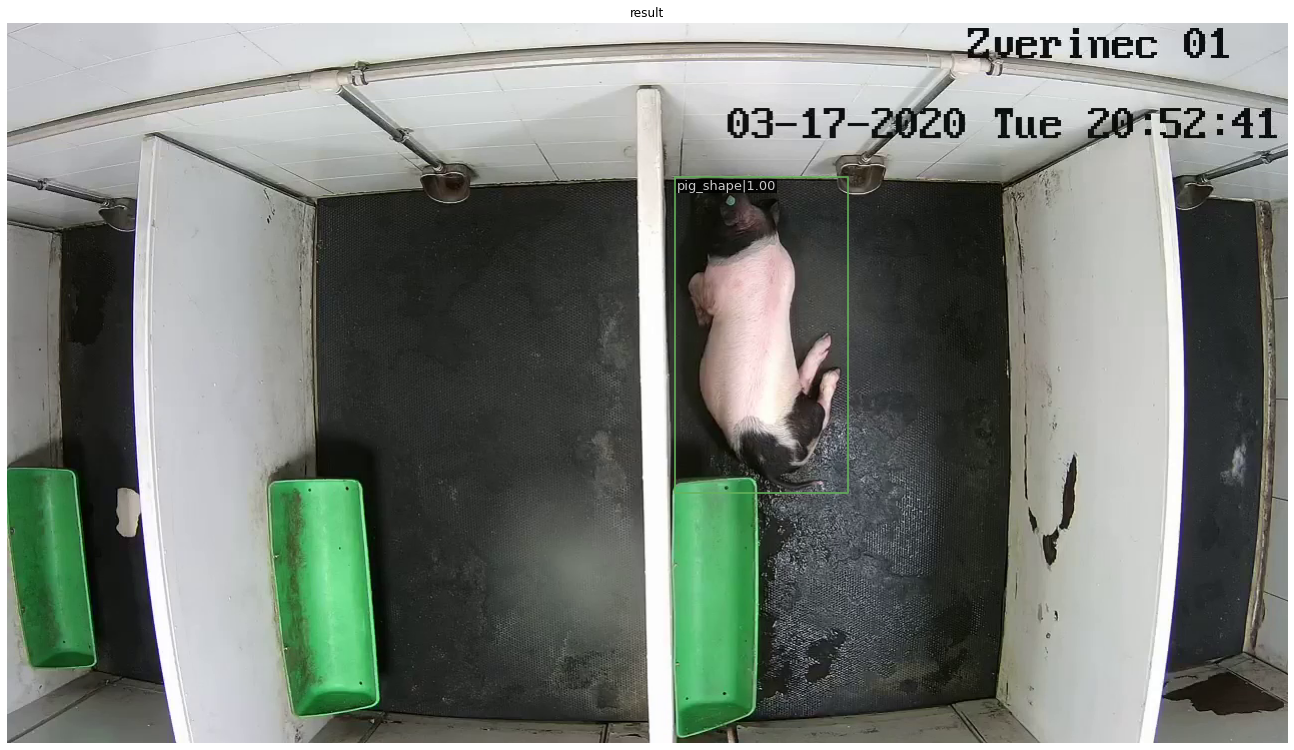

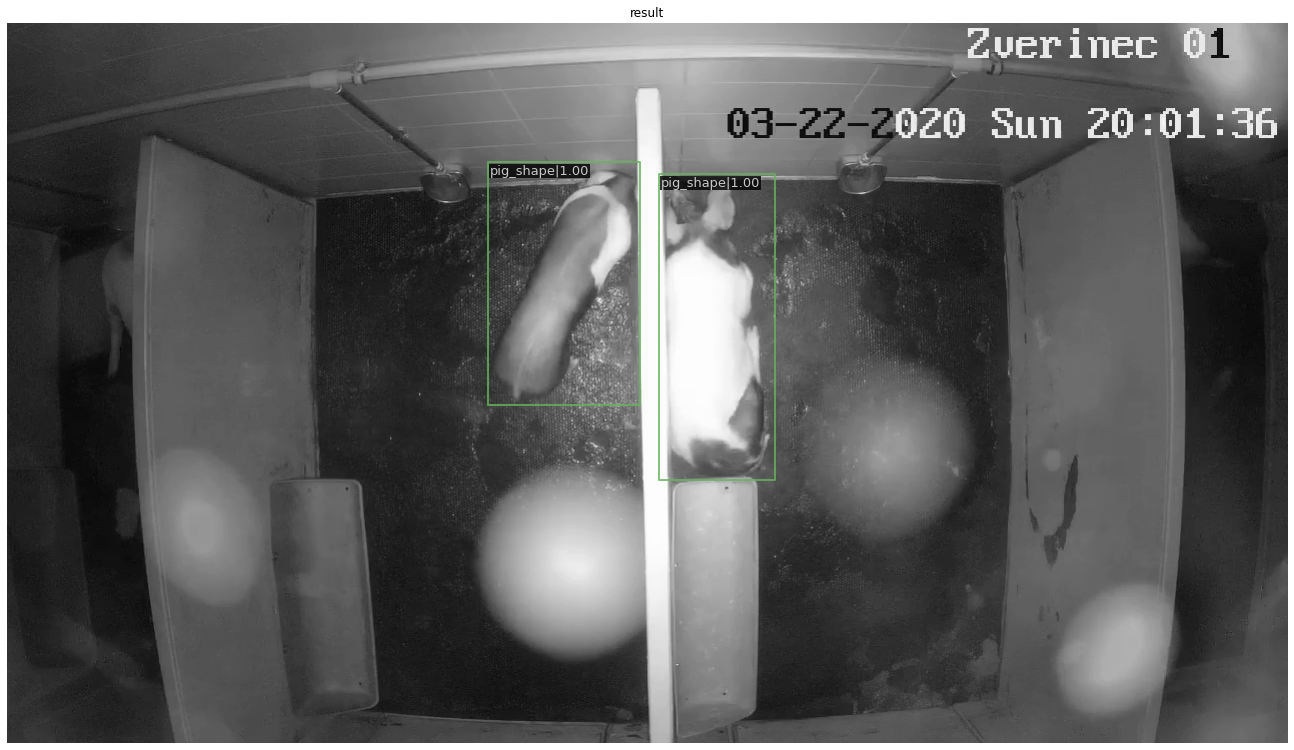

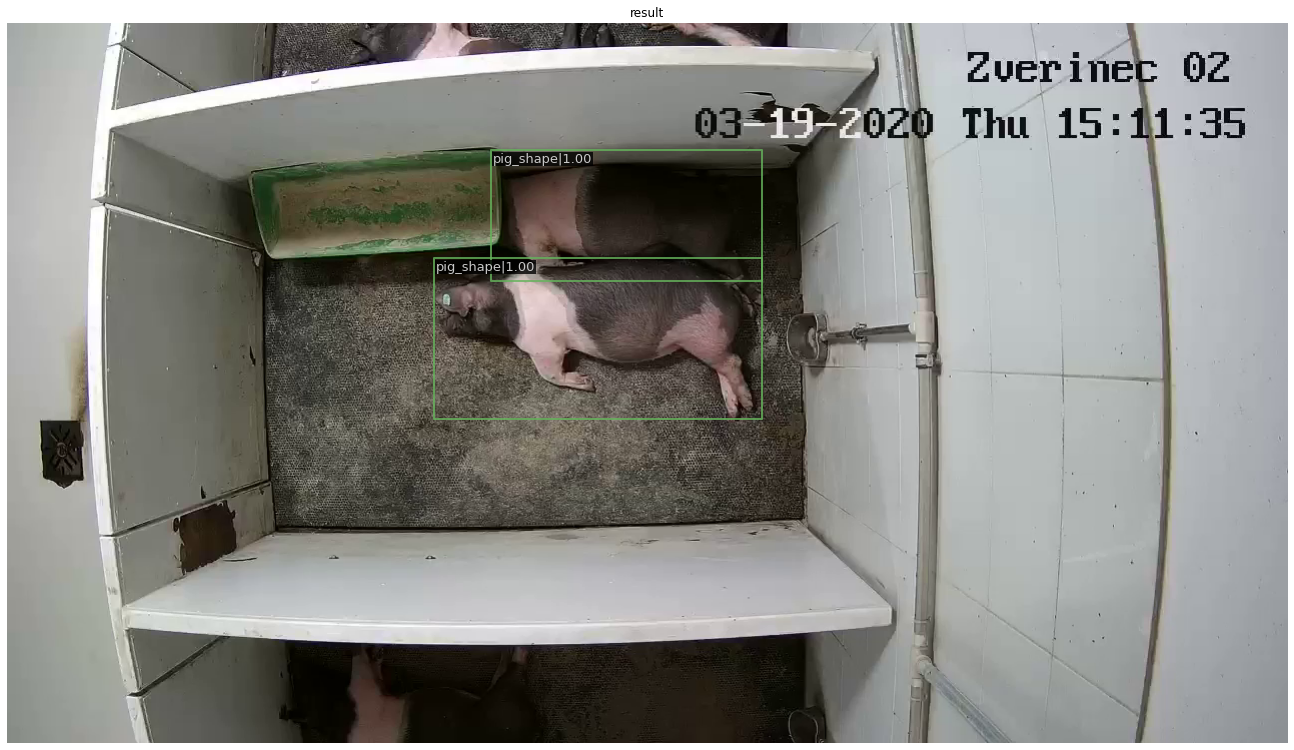

In [21]:


# path_test_images = local_input_data_dir /"images_test"
path_test_images = local_input_data_dir
# path_test_images = local_input_data_dir / cfg.data.test.img_prefix
#  = 'images/'
filelist = list((path_test_images).glob("**/*.jpg"))
filelist = list((path_test_images).glob("**/*.JPG"))
filelist.extend(list((path_test_images).glob("**/*.png")))
filelist.extend(list((path_test_images).glob("**/*.PNG")))


for img_fn in random.choices(filelist, k=3):

    # img_fn = local_input_data_dir / '/images/10.jpg'
    img = mmcv.imread(img_fn)

    model.cfg = cfg
    result = inference_detector(model, img)
    show_result_pyplot(model, img, result)
    # model.show_result(
    #     img, result, out_file=local_output_data_dir / f"pred_{img_fn.stem}.jpg"
    # )  # save image with result

# # print all files in input dir recursively to check everything

In [22]:
if len(filelist) > 1000:
    filelist_reduced = random.choices(filelist, k=1000)

for img_fn in filelist_reduced:

    # img_fn = local_input_data_dir / '/images/10.jpg'
    img = mmcv.imread(img_fn)

    model.cfg = cfg
    result = inference_detector(model, img)
    # show_result_pyplot(model, img, result)
    model.show_result(
        img, result, out_file=local_output_data_dir / f"pred_{img_fn.stem}.jpg"
    )  # save image with result

# # print all files in input dir recursively to check everything
logger.debug(str(list(map(str, list(Path(local_output_data_dir).glob("**/*"))))))

2022-09-10 04:14:30,581 - general_logger - DEBUG - ['/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/demo_output.jpg', '/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/tutorial_exps', '/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_040891.jpg', '/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_014923.jpg', '/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_033666.jpg', '/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_024721.jpg', '/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_000562.jpg', '/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_029611.jpg', '/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_018655.jpg', '/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_008786.jpg', '/scratch/mjirik/job_12639087.me

In [23]:
filelist


[PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/orig/images/frame_016195.PNG'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/orig/images/frame_012679.PNG'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/orig/images/frame_035563.PNG'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/orig/images/frame_010758.PNG'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/orig/images/frame_008035.PNG'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/orig/images/frame_002697.PNG'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/orig/images/frame_035884.PNG'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/orig/images/frame_010473.PNG'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/orig/images/frame_014083.PNG'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/orig/images/

In [24]:


!mkdir -p /storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/pigtracking/
!cp  -r "$SCRATCHDIR"/data/processed/* /storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/pigtracking/
# !cp  -r "$SCRATCHDIR"/data/processed/ /storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/$(date +"%Y-%m-%d_%H%M")

In [25]:
# LODIR = str(local_input_data_dir)
# !mkdir -p "$SCRATCHDIR"/data/proc
# # !cp -r /storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/* "$SCRATCHDIR"/data/orig
# !cp -r /storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/pigtracking.zip "$SCRATCHDIR"/data/orig
# !unzip -o "$SCRATCHDIR"/data/orig/pigtracking.zip -d "$SCRATCHDIR"/data/orig > /dev/null
# !ls "$SCRATCHDIR"/data/orig

In [26]:
list(local_output_data_dir.glob("*"))

[PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/demo_output.jpg'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/tutorial_exps'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_040891.jpg'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_014923.jpg'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_033666.jpg'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_024721.jpg'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_000562.jpg'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_029611.jpg'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_018655.jpg'),
 PosixPath('/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data

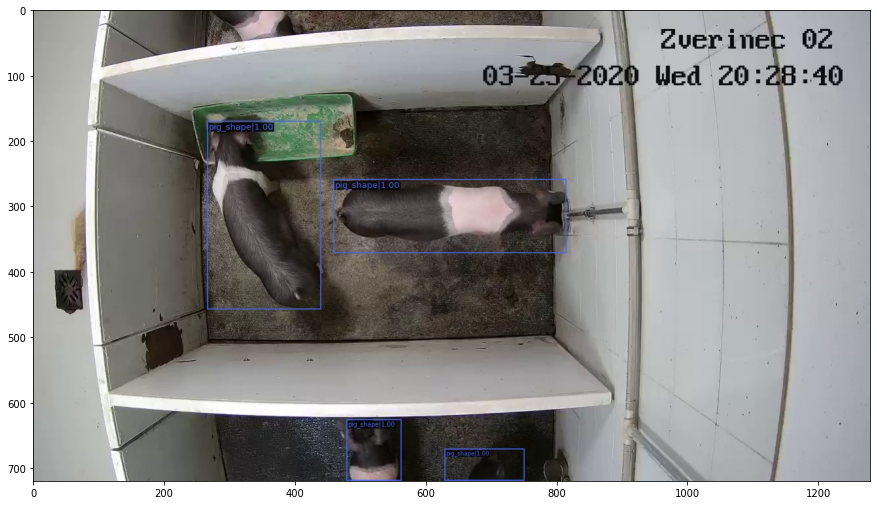

In [27]:
import skimage
import random
plt.figure(figsize=(15,10))
plt.imshow(skimage.io.imread(random.choice(list(local_output_data_dir.glob("*.jpg")))))

In [28]:
# %tensorboard --logdir /scratch/mjirik/job_12577867.meta-pbs.metacentrum.cz/data/processed/tutorial_exps

In [29]:
!ls "$SCRATCHDIR"/data/processed/*

/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/demo_output.jpg
/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_000156.jpg
/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_000191.jpg
/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_000241.jpg
/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_000260.jpg
/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_000269.jpg
/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_000276.jpg
/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_000411.jpg
/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_000425.jpg
/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_000533.jpg
/scratch/mjirik/job_12639087.meta-pbs.metacentrum.cz/data/processed/pred_frame_000562.jpg
/scratch/mjirik/

In [30]:
192643

192643